# How to simulate

In this tutorial, we are going to simulate the spread of Covid-19 in a simple, artificial population. 

First, some imports:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sid import simulate

index_cols = ["category", "subcategory", "name"]

There are four main components to a sid model: 

- `initial_states`: this is the population in the first period. 
- `contact_models`: a nested dictionary that specifies how people meet.
- `params`: parameters for the progression of the disease and the contact_models.
- `initial_infections`: A Series that contains for every individual in the initial_states if it is infected in the first period.


## Creating the initial states

Let's create an artifical population of 10 000 people. 
Every individual will be characterized by its region and age group.

The age group will affect the progression of the disease.
Both region and age group will have an influence on who our individuals are going to meet.

In [2]:
available_ages = [
        "0-9",
        "10-19",
        "20-29",
        "30-39",
        "40-49",
        "50-59",
        "60-69",
        "70-79",
        "80-100",
    ]

ages = np.random.choice(available_ages, size=10_000)
regions = np.random.choice(["North", "South"], size=10_000)

initial_states = pd.DataFrame({"age_group": ages, "region": regions})
initial_states = initial_states.astype("category")

initial_states.head(5)

,age_group,region
0,0-9,South
1,80-100,North
2,0-9,North
3,60-69,South
4,80-100,South


## Specifying the Contact Models

Next, let's define how many contacts people have every day. 
We assume people have two types of contacts, close and distant contacts. They also have fewer close than distant contacts.

In [3]:
def meet_distant(states, params):
    possible_nr_contacts = np.arange(10)
    contacts = np.random.choice(possible_nr_contacts, size=len(states))
    return pd.Series(contacts, index=states.index)


def meet_close(states, params):
    possible_nr_contacts = np.arange(5)
    contacts = np.random.choice(possible_nr_contacts, size=len(states))
    return pd.Series(contacts, index=states.index)


assort_by = ["age_group", "region"]

contact_models = {
    "distant": {"model": meet_distant, "assort_by": assort_by, "is_recurrent": False},
    "close": {"model": meet_close, "assort_by": assort_by, "is_recurrent": False},
}

## Specifying the model parameters

sid allows to estimate one infection probability per contact type. 
In this example, close contacts are more infectious than distant contacts with 5% versus 3%. 

In [4]:
inf_params = pd.read_csv("infection_probs.csv", index_col=index_cols)
inf_params

value  note  source
category       subcategory name                        
infection_prob close       close     0.05   NaN     NaN
               distant     distant   0.03   NaN     NaN

Similarily, we specify for each contact model how assortatively
people meet across their respective `assort_by` keys. 

We assume that 90% of contacts are with people from the same region and 50% with contacts of the same age group as oneself for both "meet_close" and "meet_distant". 
The rest of the probability mass is split evenly between the other regions and age groups.

In [5]:
assort_probs = pd.read_csv("assort_by_params.csv", index_col=index_cols)
assort_probs

value  note  source
category             subcategory name                          
assortative_matching close       age_group    0.5   NaN     NaN
                                 region       0.9   NaN     NaN
                     distant     age_group    0.5   NaN     NaN
                                 region       0.9   NaN     NaN

Lastly, we load some parameters that specify how Covid-19 progresses. This includes asymptomatic cases and covers that sever cases are more common among the elderly.

`cd_` stands for countdown. When a countdown is -1 the event never happens. So for example, 25% of infected people will never develop symptoms and the rest will develop symptoms 3 days after they start being infectious. 

In [6]:
disease_params = pd.read_csv("../../../src/sid/covid_epi_params.csv", index_col=index_cols)
disease_params.head(6).round(2)

value
category           subcategory        name                     
health_system      icu_limit_relative icu_limit_relative   0.00
cd_immune_false    all                1000                 1.00
cd_infectious_true all                1                    0.12
                                      2                    0.12
                                      3                    0.21
                                      4                    0.17

In [7]:
params = pd.concat([disease_params, inf_params, assort_probs])

# This tutorial does not include testing so we dea
params.loc["cd_knows_true","all", -1] = 1.0

## Contact Policies

We also allow the government to react to the rising number of infections by enforcing a
mild curfew which halves the contacts of all individuals if 10% of all individuals are
infectious.

You could also implement policies inside the contact models. This allows you more flexibility. For example, we could implement that sick individuals stay home, that vulnerable people react with stricter social distancing or implement the [locally adaptive lockdown policy in Germany](https://www.dw.com/en/merkel-cautiously-optimistic-as-she-announces-lockdown-rollback/a-53346427).

In [8]:
def contact_policy_is_active(states):
    return states["infectious"].mean() > 0.1


contact_policies = {
    "close": {
        "start": "2020-03-12",
        "multiplier": 0.5,
        "is_active": contact_policy_is_active,
    },
    "distant": {
        "start": "2020-03-12",
        "multiplier": 0.5,
        "is_active": contact_policy_is_active,
    },
}

Finally, there must be some initial infections in our population.

In [9]:
initial_infections = pd.Series(data=False, index=initial_states.index)

infected_individuals = initial_infections.sample(100, random_state=0).index
initial_infections.loc[infected_individuals] = True

## Run the simulation

We are going to simulate this population for 200 periods.

In [10]:
df = simulate(
    initial_states=initial_states,
    contact_models=contact_models,
    params=params,
    contact_policies=contact_policies,
    initial_infections=initial_infections,
    duration={"start": "2020-02-27", "periods": 200},
    seed=0,
)
df.head(5)

,index,age_group,region,ever_infected,immune,infectious,knows,symptomatic,needs_icu,dead,cd_infectious_false,n_has_infected,date,period,missed_close,missed_distant,n_contacts_close,n_contacts_distant,newly_infected
0,0,0-9,South,False,False,False,False,False,False,False,-3,0,2020-02-27,0,0,0,0,0,False
1,1,80-100,North,False,False,False,False,False,False,False,-3,0,2020-02-27,0,0,0,0,0,False
2,2,0-9,North,False,False,False,False,False,False,False,-3,0,2020-02-27,0,0,0,0,0,False
3,3,60-69,South,False,False,False,False,False,False,False,-3,0,2020-02-27,0,0,0,0,0,False
4,4,80-100,South,False,False,False,False,False,False,False,-3,0,2020-02-27,0,0,0,0,0,False


The return of `simulate` is a [Dask DataFrame](https://docs.dask.org/en/latest/dataframe.html) which lazily loads the data. If your data fits your working memory, do the following to convert it to a pandas DataFrame.

In [11]:
df = df.compute()

Let us take a look at various statistics of the sample.

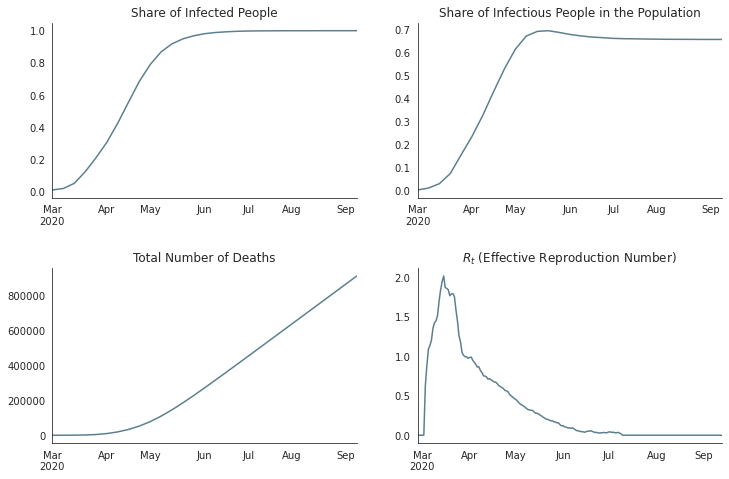

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(bottom=0.15, wspace=0.2, hspace=0.4)

axs = axs.flatten()

df.resample("W", on="date")["ever_infected"].mean().plot(ax=axs[0], color="#5c7f8e")
df.resample("W", on="date")["infectious"].mean().plot(ax=axs[1], color="#5c7f8e")
df.resample("W", on="date")["dead"].sum().cumsum().plot(ax=axs[2], color="#5c7f8e")
infectious_last_seven_days = df.cd_infectious_false.between(-7, 0)
df.loc[infectious_last_seven_days].resample("D", on="date")[
    "n_has_infected"
].mean().plot(ax=axs[3], color="#5c7f8e")

for ax in axs:
    ax.set_xlabel("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

axs[0].set_title("Share of Infected People")
axs[1].set_title("Share of Infectious People in the Population")
axs[2].set_title("Total Number of Deaths")
axs[3].set_title("$R_t$ (Effective Reproduction Number)")

plt
plt.show()